# Tomato disease classification

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
           "PlantVillage",
            shuffle = True,
            image_size = (IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [5]:
classes = dataset.class_names
classes

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

### Exploring the data

In [6]:
len(dataset) # there are 321 batches

321

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(50, 256, 256, 3)
[4 6 7 2 7 7 4 4 5 6 2 3 4 7 6 7 2 5 4 4 2 4 3 4 0 6 1 7 9 5 2 0 6 5 9 7 0
 5 2 2 5 9 7 7 5 0 0 3 2 1]


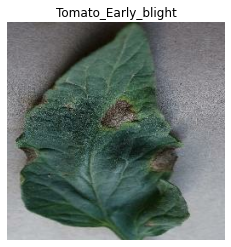

In [8]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(classes[label_batch[0]])
    plt.axis("off")

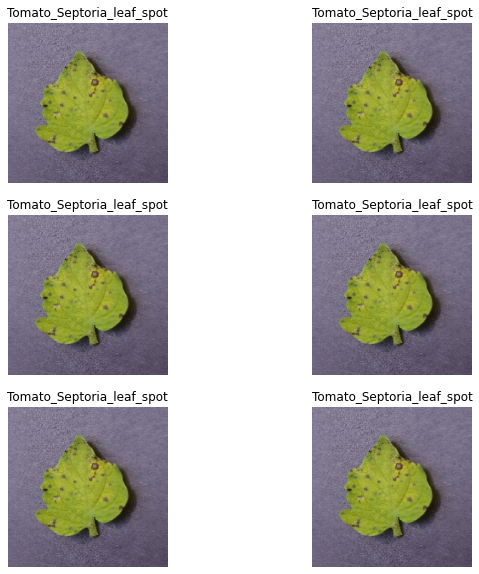

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3,2,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(classes[label_batch[0]])
        plt.axis("off")

#### lets take 80% data for training 10% data for validation and 10% data for testing

In [10]:
train_size = 0.8
len(dataset)*train_size

256.8

In [11]:
train_data = dataset.take(256)
len(train_data)

256

In [12]:
testing = dataset.skip(256)
len(testing)

65

In [13]:
val_size = 0.1
len(dataset)*val_size

32.1

In [14]:
val_data = testing.take(32)
len(val_data)

32

In [15]:
test_data = testing.skip(32)
len(test_data)

33

#### Creating a function which directly splits the data

In [16]:
def get_splitted_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)            #seed argument makes sure the next shuffling should be different
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_data, val_data, test_data = get_splitted_dataset_tf(dataset)

In [18]:
len(train_data), len(val_data), len(test_data)

(256, 32, 33)

### Optimizing tensorflow input pipeline

In [19]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)#prefetch--> pulls extra batch for training
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)#cache--> reduces the memory ussage during running epochs
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling((1.0/255))
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])
model.build(input_shape = input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (50, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (50, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (50, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (50, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (50, 125, 125, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (50, 62, 62, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (50, 60, 60, 32)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
EPOCHS=50
history = model.fit(
    train_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_data
    )

Epoch 1/50
256/256 [==============================] - 512s 2s/step - loss: 0.2758 - accuracy: 0.9028 - val_loss: 0.6098 - val_accuracy: 0.8056
Epoch 2/50
256/256 [==============================] - 510s 2s/step - loss: 0.2692 - accuracy: 0.9057 - val_loss: 0.4388 - val_accuracy: 0.8537
Epoch 3/50
256/256 [==============================] - 531s 2s/step - loss: 0.2380 - accuracy: 0.9173 - val_loss: 0.4244 - val_accuracy: 0.8569
Epoch 4/50
256/256 [==============================] - 653s 3s/step - loss: 0.2307 - accuracy: 0.9172 - val_loss: 0.3363 - val_accuracy: 0.8763
Epoch 5/50
256/256 [==============================] - 710s 3s/step - loss: 0.2237 - accuracy: 0.9199 - val_loss: 0.3902 - val_accuracy: 0.8681
Epoch 6/50
256/256 [==============================] - 721s 3s/step - loss: 0.2096 - accuracy: 0.9256 - val_loss: 0.2810 - val_accuracy: 0.8963
Epoch 7/50
256/256 [==============================] - 715s 3s/step - loss: 0.2021 - accuracy: 0.9292 - val_loss: 0.4115 - val_accuracy: 0.8675

In [28]:
model.evaluate(test_data)

33/33 [==============================] - 21s 640ms/step - loss: 0.0678 - accuracy: 0.9770


[0.0677739828824997, 0.9769697189331055]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 256}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

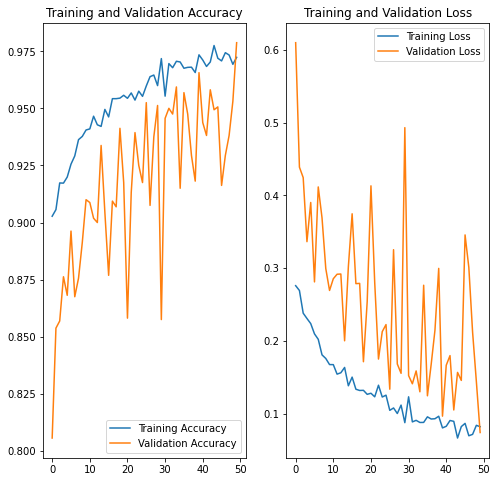

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

## Predictions

image to predict
actual label: Tomato__Tomato_YellowLeaf__Curl_Virus
Prediction : Tomato__Tomato_YellowLeaf__Curl_Virus


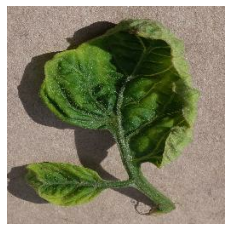

In [36]:
import numpy as np
for images_batch, labels_batch in test_data.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("image to predict")
    plt.imshow(first_image)
    print("actual label:", classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Prediction :", classes[np.argmax(batch_prediction[0])])
    plt.axis('off')
    

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

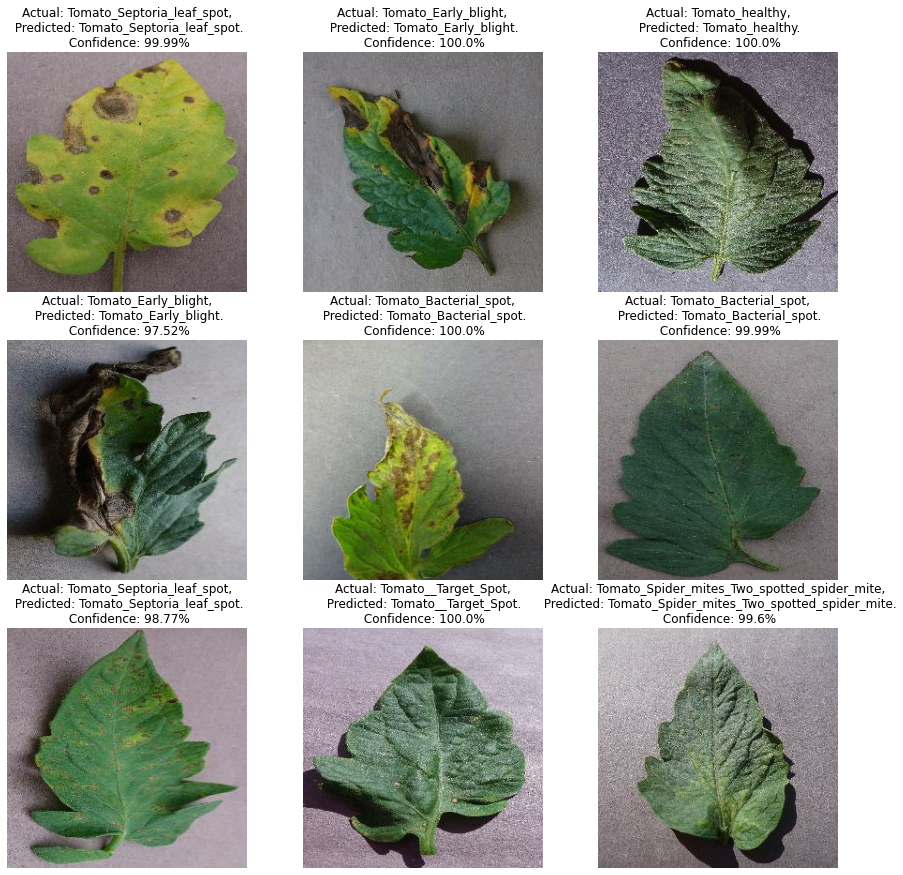

In [46]:
plt.figure(figsize=(15,15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis('off')

In [47]:
model.save(f"../models/{1}")

INFO:tensorflow:Assets written to: ../models/1\assets
